In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

# import the model architecture
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

#import optimizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.6.0


In [3]:
# creating the base of the Model - DenseNet201
base_model=DenseNet201(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

# adding activation layers to the model
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# output layer for two classes
preds=Dense(2,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block30_concat (Concatena (None, 4, 4, 1856)   0           conv5_block29_concat[0][0]       
                                                                 conv5_block30_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block31_0_bn (BatchNormal (None, 4, 4, 1856)   7424        conv5_block30_concat[0][0]       
__________________________________________________________________________________________________
conv5_block31_0_relu (Activatio (None, 4, 4, 1856)   0           conv5_block31_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block31_1_conv (Conv2D)   (None, 4, 4, 128)    237568      conv5_block31_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block31_1_bn (BatchNormal (None, 4, 4, 128)    512         conv5_block31_1_conv[0][0]       
__________

In [5]:
# change the number of trainable parameters
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
    

In [6]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block24_1_conv (Conv2D)   (None, 4, 4, 128)    208896      conv5_block24_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 4, 4, 128)    512         conv5_block24_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_relu (Activatio (None, 4, 4, 128)    0           conv5_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_2_conv (Conv2D)   (None, 4, 4, 32)     36864       conv5_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_concat (Concatena (None, 4, 4, 1664)   0           conv5_block23_concat[0][0]       
                                                                 conv5_block24_2_conv[0][0]       
__________

In [7]:
def takeData(DATAPATH, CATEGORIES):
    img_array = []
    for category in CATEGORIES:
        path_cases = os.path.join(DATAPATH, category)
        n = len(os.listdir(path_cases))
        for i in range(n):
            path_case = os.path.join(path_cases, "{} ({})".format(CATEGORIES[category], i+1))
            k = 0
            m = len(os.listdir(path_case))//2
            for img in os.listdir(path_case):
                k += 1
                if m==k:
                    img_arr = cv2.imread(os.path.join(path_case, img))
                    new_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                    img_array.append([new_arr, category])
                    break
    return img_array

In [8]:
CATEGORIES ={"non-COVID-19/CP" : 0, "COVID-19" : 1}
DATAPATH = "data/studies/data"
IMG_SIZE = 128

# take the dataset of masked images of COVID and non_COVID cases
data_array = takeData(DATAPATH, CATEGORIES)
# check the number of samples
print(len(data_array)) 

828


In [9]:
# shuffle the data
random.seed(0)
random.shuffle(data_array)

# divide the data into images and labels
image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])

image_data = np.array(image_data, dtype="float32") / 255.0

# change the labels into label binarizer([1, 0] and [0, 1] instead of names)
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))

In [10]:
# divide the dataset into train and test sets
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(662, 128, 128, 3) (166, 128, 128, 3)


In [36]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
                    steps_per_epoch=xtrain.shape[0] //128,
                    epochs=10,
                    verbose=2,
                    callbacks=[anne, checkpoint],
                    validation_data=(xtrain, ytrain))

Epoch 1/10
5/5 - 6s - loss: 0.0405 - accuracy: 0.9925 - val_loss: 0.0104 - val_accuracy: 0.9955

Epoch 00001: val_loss improved from inf to 0.01039, saving model to model.h5
Epoch 2/10
5/5 - 5s - loss: 0.0609 - accuracy: 0.9757 - val_loss: 0.0094 - val_accuracy: 0.9985

Epoch 00002: val_loss improved from 0.01039 to 0.00941, saving model to model.h5
Epoch 3/10
5/5 - 6s - loss: 0.0626 - accuracy: 0.9775 - val_loss: 0.0071 - val_accuracy: 0.9985

Epoch 00003: val_loss improved from 0.00941 to 0.00707, saving model to model.h5
Epoch 4/10
5/5 - 5s - loss: 0.0470 - accuracy: 0.9831 - val_loss: 0.0088 - val_accuracy: 0.9985

Epoch 00004: val_loss did not improve from 0.00707
Epoch 5/10
5/5 - 6s - loss: 0.0556 - accuracy: 0.9813 - val_loss: 0.0089 - val_accuracy: 0.9970

Epoch 00005: val_loss did not improve from 0.00707
Epoch 6/10
5/5 - 5s - loss: 0.0639 - accuracy: 0.9757 - val_loss: 0.0074 - val_accuracy: 0.9970

Epoch 00006: val_loss did not improve from 0.00707
Epoch 7/10
5/5 - 6s - loss

In [37]:
ypred = model.predict(xtest)

total = 0
accurate = 0
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 166 	accurately-predicted-data: 156 	 wrongly-predicted-data:  10
Accuracy: 93.976 %


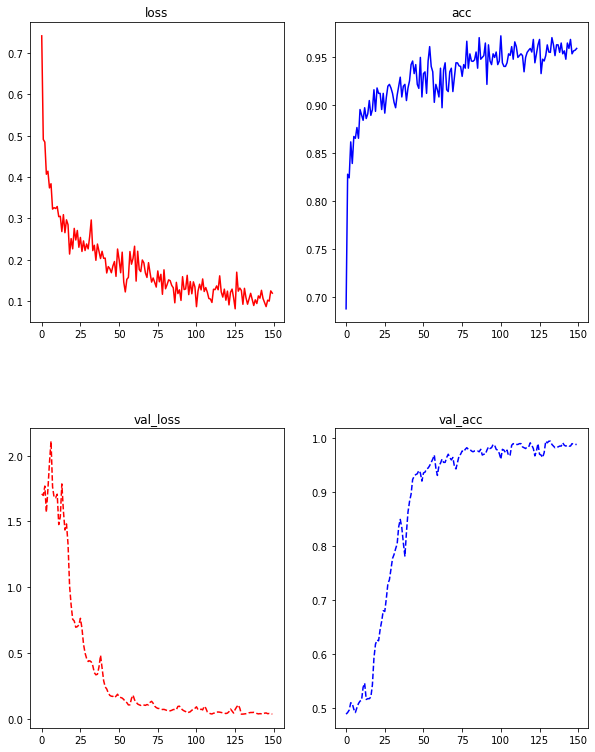

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')


In [38]:
class_names = ['non-Covid-19', 'Covid-19']
y_pred_labels =[]
y_true_labels = []
for i in range(len(ypred)):
    y_pred_labels.append(class_names[np.argmax(ypred[i])])
    y_true_labels.append(class_names[np.argmax(ytest[i])])

Confusion matrix
[[63  9]
 [ 1 93]]


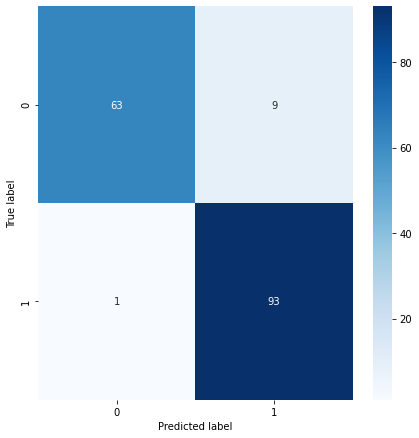

In [39]:
from sklearn.metrics import plot_confusion_matrix
disp = confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels,
                                 labels=class_names,
                                 normalize=None)


print("Confusion matrix")
print(disp)
figure = plt.figure(figsize=(6, 6))
sns.heatmap(disp, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()